## Tasks with Sequential Data 
- Feed forward networks are not so efficent to deal with tasks with sequential data. 
    - fixed size vector input and output.
    - do not make use of the sequential relationship explicitly.


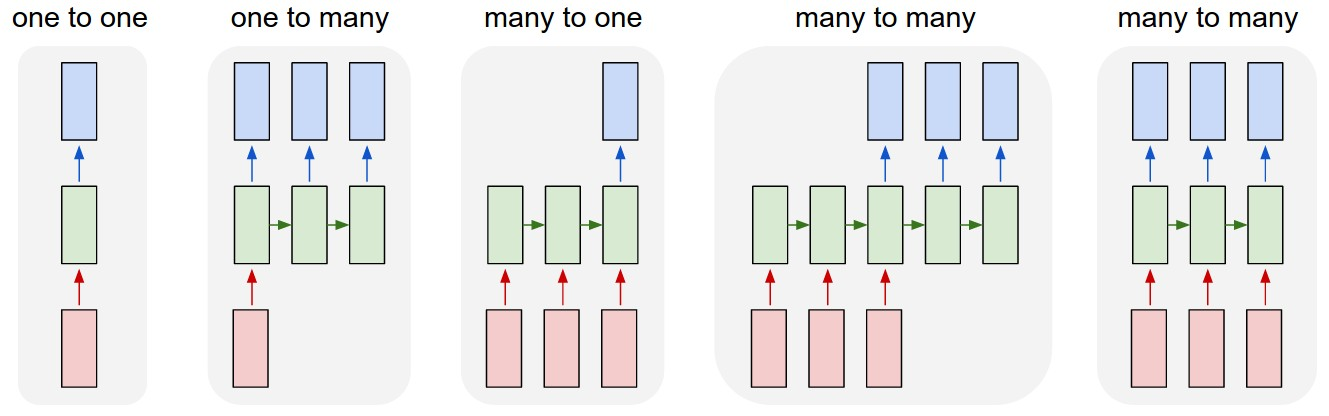


- one to one example 
    - language sloting 
    

## Traditional method

e.g  The Autoregressive–moving-average model

$X_t = c + \varepsilon_t + \sum_i^p \phi_i X_{t-i} + \sum_i^q \theta_i \varepsilon_{t-i} $

Assume that $X_t$ is subject to the model ARMA(p, q) first, then evaluate the parameters by fitting the data. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
def getSample(n, x0 = np.array([]), ar = np.array([]), ma = np.array([]), c = 0, sig= 1):
    p, q = len(ar), len(ma)
    e = sig * np.random.randn(n+q)
    x = np.empty(n + p)
    x[:p] = x0[-p:]
    for i in range(n):
        x[p+i] = c + e[i+q] + x[i:i+p].dot(ar) + e[i:i+q].dot(ma)
    return x
        
# random walk    
x = getSample(200, x0= np.array([0]), ar = np.array([1]) )
plt.plot(x)
plt.show()

# white noise
x = getSample(200)
plt.plot(x)
plt.show()


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

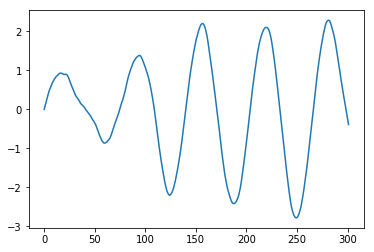

In [2]:
x = getSample(300, x0= np.array([0,0.1]), ar = np.array([-1,1.99]), sig=0.01)
plt.plot(x)
plt.show()

In [3]:
import network as nw
from loss import Lossl2
from optimizer import Gradientdescent
N_train, N_test = 200, 50

x_train, x_test = x[:N_train], x[N_train:N_train+N_test]
y_train, y_test = x[1:N_train+1], x[1+N_train: 1+N_train+N_test]

layers = [nw.RnnLayer(1,1, activation = None)]     

net = nw.NeuralNetwork(layers, Lossl2, optimizer = Gradientdescent(alpha = 4, decay_rate = 0.999))
net.train(x_train, y_train, max_iter = 1000, print_every = 100, batch_size = None)

xp = net.predict(x_test)

[0.]
[0.]


NameError: name 'h' is not defined

# LSTM
If you read recent papers, you'll see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$


![image.png](LSTM.png)
Image by François Deloche, via Wikimedia Commons